# PEC 3 




## Parte 1 : RDF y RDFS


En este notebook vamos a utilizar algunas librerías python útiles para trabajar con tripletas:

*   `rdflib` para trabajar con tripletas RDF
*   `rdflib-jsonld` para usar JSON-LD
*   `SPARQLWrapper` para ejecutar consultas SPARQL e importar los resultados en el notebook
*   `pydotplus` y `graphviz` para visualizar los grafos.



In [1]:
! pip install rdflib
! pip install rdflib-jsonld
! pip install -q sparqlwrapper  
! pip install pydotplus
! pip install graphviz

     |████████████████████████████████| 407 kB 36.3 MB/s 
     |████████████████████████████████| 45 kB 3.9 MB/s 


In [2]:
import io
from rdflib import Graph as RDFGraph
from rdflib import Namespace, URIRef, Literal, BNode
from rdflib.namespace import NamespaceManager
from rdflib.namespace import CSVW, DC, DCAT, DCTERMS, DOAP, FOAF, ODRL2, ORG, OWL, \
                           PROF, PROV, RDF, RDFS, SDO, SH, SKOS, SOSA, SSN, TIME, \
                           VOID, XMLNS, XSD
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import rdflib_jsonld
from SPARQLWrapper import SPARQLWrapper, JSON, XML, N3, RDF , POST, GET, POSTDIRECTLY, CSV

import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import pprint
import statistics
import collections
import warnings
warnings.filterwarnings ("ignore")

/usr/local/lib/python3.7/dist-packages/rdflib_jsonld/__init__.py:12: DeprecationWarning: The rdflib-jsonld package has been integrated into rdflib as of rdflib==6.0.1.  Please remove rdflib-jsonld from your project's dependencies.
  DeprecationWarning,



Las funciones de la librería `rdflib` permiten convertir los datos en un grafo `RDFGraph` con el que cargar los datos.



In [3]:
demo = '''\
<http://bigasterisk.com/foaf.rdf#drewp> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://xmlns.com/foaf/0.1/Person> .
<http://bigasterisk.com/foaf.rdf#drewp> <http://example.com/says>  "Hello world" .
'''

g = RDFGraph()  # crear objeto grafo en el que cargar datos
g.parse( data=demo, format ="n3") # carga los datos demo

print(len(g)) # ver cuántas tripletas : 2

for stmt in g:
    pprint.pprint(stmt)   # imprimir las tripletas



2
(rdflib.term.URIRef('http://bigasterisk.com/foaf.rdf#drewp'),
 rdflib.term.URIRef('http://example.com/says'),
 rdflib.term.Literal('Hello world'))
(rdflib.term.URIRef('http://bigasterisk.com/foaf.rdf#drewp'),
 rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
 rdflib.term.URIRef('http://xmlns.com/foaf/0.1/Person'))


Es posible extraer los datos usando las [funciones incluidas](https://rdflib.readthedocs.io/en/stable/) en el paquete `rdflib`:




In [4]:
for h, r, t in g.triples((None,None,None)):
  print( " %s  -- %s --> %s  "  % (h, r ,t) )

print  ()
print ("Sujetos")
print ("----------")
for p in g.subjects():
  print (p)

print ("Predicados")
print ("----------")
for p in g.predicates():
  print (p)

print ("Objetos")
print ("----------")
for p in g.objects():
  print (p)

 http://bigasterisk.com/foaf.rdf#drewp  -- http://example.com/says --> Hello world  
 http://bigasterisk.com/foaf.rdf#drewp  -- http://www.w3.org/1999/02/22-rdf-syntax-ns#type --> http://xmlns.com/foaf/0.1/Person  

Sujetos
----------
http://bigasterisk.com/foaf.rdf#drewp
http://bigasterisk.com/foaf.rdf#drewp
Predicados
----------
http://example.com/says
http://www.w3.org/1999/02/22-rdf-syntax-ns#type
Objetos
----------
Hello world
http://xmlns.com/foaf/0.1/Person


También es posible  consultar las tripletas almacenadas en un grafo mediante consultas SPARQL.

In [5]:
q ='''
    SELECT ?h ?r ?t
     WHERE {
        ?h ?r ?t 
     }
'''

result = g.query (q)

for row in result:
    pprint.pprint(row)   # imprimir las tripletas


(rdflib.term.URIRef('http://bigasterisk.com/foaf.rdf#drewp'),
 rdflib.term.URIRef('http://example.com/says'),
 rdflib.term.Literal('Hello world'))
(rdflib.term.URIRef('http://bigasterisk.com/foaf.rdf#drewp'),
 rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'),
 rdflib.term.URIRef('http://xmlns.com/foaf/0.1/Person'))


Aunque resulta a veces útil representarlas como grafos.

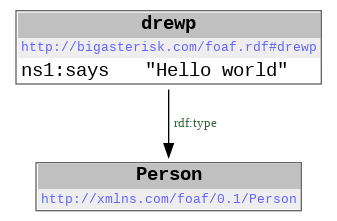

In [6]:
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))


visualize(g)

Con el grafo es posible obtener cualquiera de los otros formatos RDF  con la función `serialize`.

In [7]:
target_pretty = g.serialize ( format="pretty-xml")
print ( target_pretty )

<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF
  xmlns:ns3="http://xmlns.com/foaf/0.1/"
  xmlns:ns1="http://example.com/"
  xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
>
  <ns3:Person rdf:about="http://bigasterisk.com/foaf.rdf#drewp">
    <ns1:says>Hello world</ns1:says>
  </ns3:Person>
</rdf:RDF>



Con *RDF Schema* se pueden especificar clases y jerarquías.

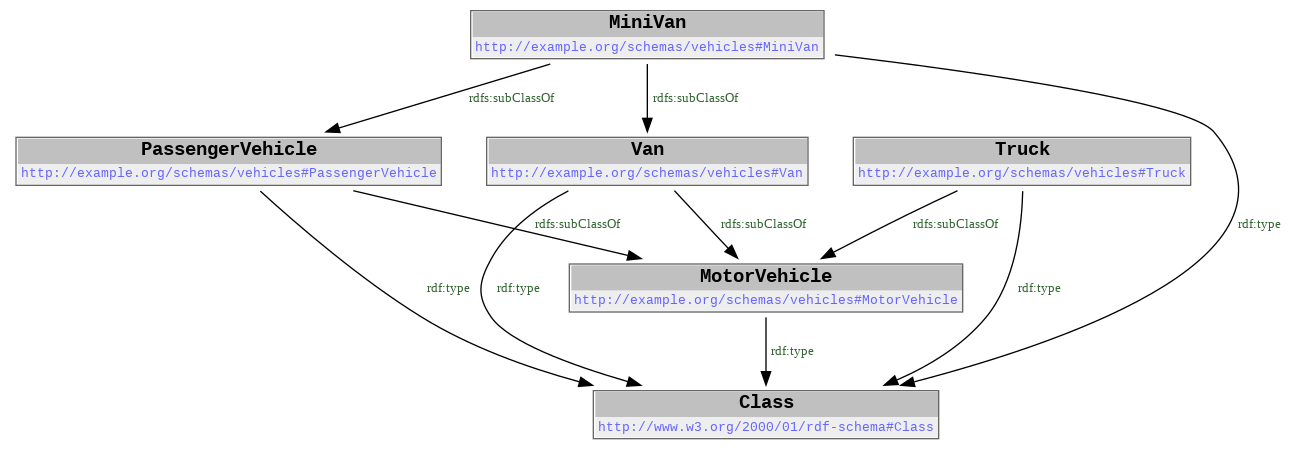

In [8]:
vehicles_data = """\
@prefix ex: <http://example.org/schemas/vehicles#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
ex:MotorVehicle       rdf:type          rdfs:Class .
ex:PassengerVehicle   rdf:type          rdfs:Class .
ex:Van                rdf:type          rdfs:Class .
ex:Truck              rdf:type          rdfs:Class .
ex:MiniVan            rdf:type          rdfs:Class .

ex:PassengerVehicle   rdfs:subClassOf   ex:MotorVehicle .
ex:Van                rdfs:subClassOf   ex:MotorVehicle .
ex:Truck              rdfs:subClassOf   ex:MotorVehicle .

ex:MiniVan            rdfs:subClassOf   ex:Van .
ex:MiniVan            rdfs:subClassOf   ex:PassengerVehicle .
"""

veh_g = RDFGraph()
veh_g.parse (data=vehicles_data, format="n3")
visualize ( veh_g )

Como `rdfs:SubClass` es transitiva y reflexiva, es posible deducir hechos que no están directamente explicitados en las tripletas originales. Si hacemos una consulta para seleccionar los vehículos de motor con SPARQL:

In [9]:
result = veh_g.query("""
SELECT DISTINCT ?s
WHERE
{
  ?s ?p ?o .
  ?s rdfs:subClassOf+ ex:MotorVehicle .
}
""", initNs={ 'rdfs': RDFS, 'rdf' : RDF, 'ex' : 'http://example.org/schemas/vehicles#' })

for row in result:
  print (row)

(rdflib.term.URIRef('http://example.org/schemas/vehicles#PassengerVehicle'),)
(rdflib.term.URIRef('http://example.org/schemas/vehicles#MiniVan'),)
(rdflib.term.URIRef('http://example.org/schemas/vehicles#Van'),)
(rdflib.term.URIRef('http://example.org/schemas/vehicles#Truck'),)


Advertir que tanto `MiniVan` se muestra como `MotorVehicle` aunque no hay una tripleta que lo indique explícitamente (transitivamente a través de `PassengerVehicle`). 

### EJERCICIO



Vamos a trabajar con las siguientes tripletas. Completar las elementos de las tripletas que faltan para obtener un grafo consistente sobre películas, actores y directores.


In [10]:
prefixes = """\
@prefix :	<http://example.org/demo/#> .
@prefix rdf:	<http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs:	<http://www.w3.org/2000/01/rdf-schema#> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .

"""

data = """\
:Person rdf:type rdfs:Class. # TODO 

:Actor rdfs:type rdfs:Class;
       rdfs:subclassOf :Person . # TODO 

:Director rdfs:type rdfs:Class;
          rdfs:subclassOf  :Person . # TODO 

:Movie rdfs:type rdfs:Class . # TODO 

:hasActor rdf:type  rdf:Property;   # TODO 
             rdfs:range :Movie;    # TODO 
             rdfs:domain :Actor .  # TODO 

:hasDirector rdf:type rdf:Property;  # TODO 
             rdfs:range :Movie;      # TODO rdfs:_______ :___________
             rdfs:domain :Director . # TODO rdfs:_______ :___________

:nolan rdf:type :Director;             #TODO rdf:_______
       rdfs:label "Christopher Nolan". 

:dicaprio rdf:type :Actor;              #TODO 
         rdfs:label "Leonardo DiCaprio".      #TODO 

:hardy rdf:type :Actor;        #TODO 
         rdfs:label "Tom Hardy".     #TODO 

:inception  rdf:type :Movie;         #TODO 
            rdfs:label "Inception"@en;    #TODO 
            rdfs:label "Origen"@es;       #TODO 
            :hasDirector :nolan;          #TODO 
            :hasActor :dicaprio;          #TODO 
            :hasActor :hardy .           #TODO 


:eastwood   rdf:type :Director;          #TODO 
            rdf:type :Actor;             #TODO 
            rdfs:label "Clint_Eastwood". 


:milliondollarbaby  rdf:type :Movie;                   #TODO 
                    rdfs:label "Million Dollar Baby"@en;    #TODO 
                    :hasDirector :eastwood;                       #TODO  
                    :hasActor  :eastwood .                     #TODO 


:jedgar rdf:type :Movie;             #TODO  
        rdfs:label "J. Edgar"@en;    #TODO 
        :hasDirector :eastwood;            #TODO  
        :hasActor :dicaprio .           #TODO  

:batman  rdf:type :Movie;                   #TODO 
         rdfs:label "The Dark Knight Rises"@en;  #TODO 
         :hasDirector      :nolan;                     #TODO  
         :hasActor  :hardy .                        #TODO  

"""


gx = RDFGraph()

gx.parse( data=prefixes+data, format ="n3") # TODO 



<Graph identifier=N66e18ed761924ac2abaa5e37ada63196 (<class 'rdflib.graph.Graph'>)>

In [11]:
# TODO: Cuántas tripletas hay en el grafo
print(len(gx))


39


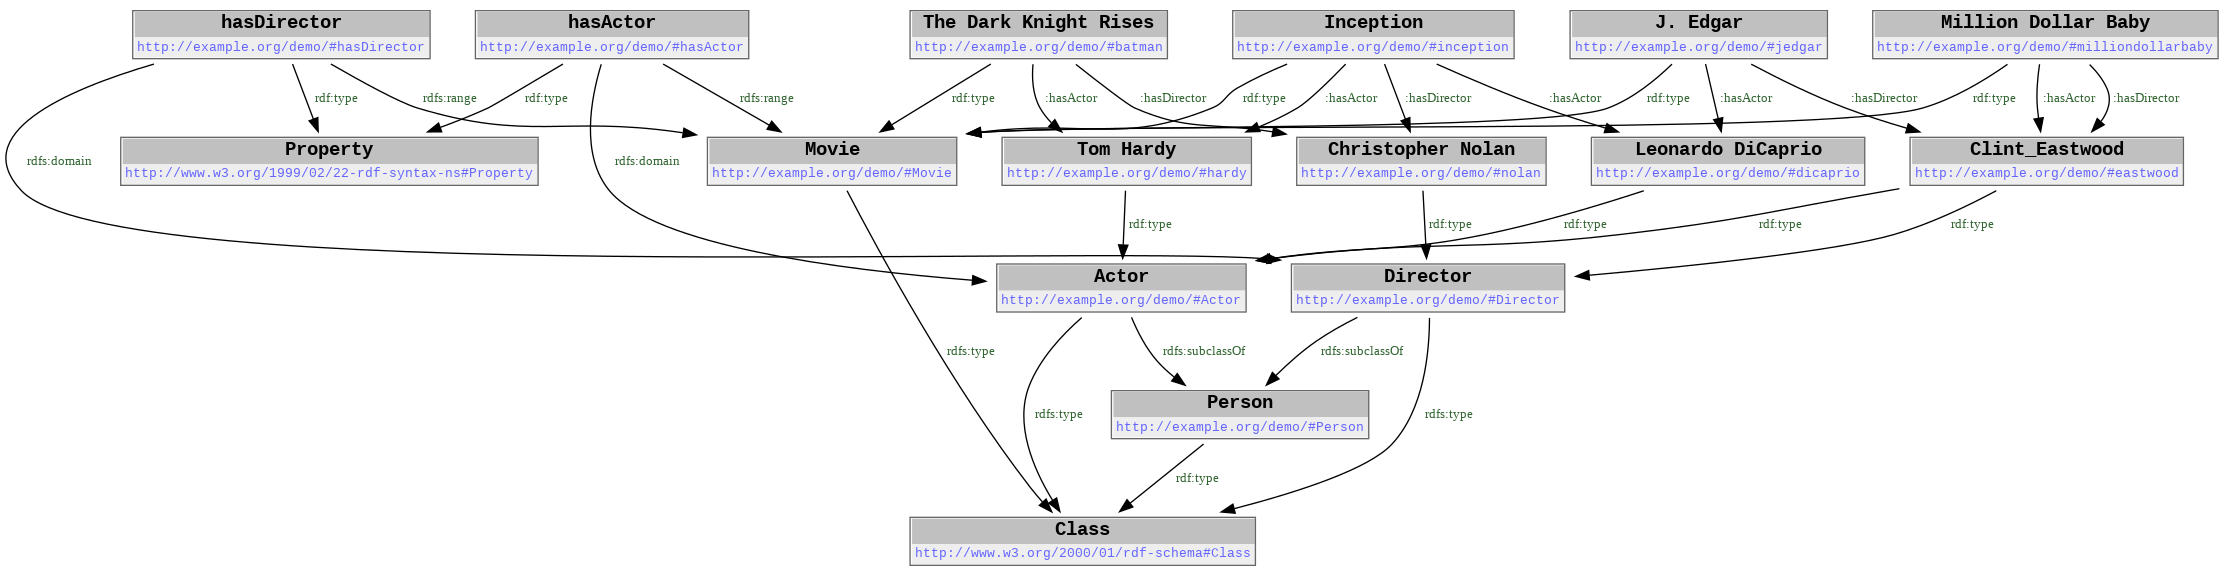

In [12]:
# TODO: visualizar el grafo
visualize(gx)

Serializar el grafo obtenido como documento JSON-LD:

In [95]:


print(gx.serialize(format='json-ld', indent=8))


[
        {
                "@id": "http://example.org/demo/#nolan",
                "@type": [
                        "http://example.org/demo/#Director"
                ],
                "http://www.w3.org/2000/01/rdf-schema#label": [
                        {
                                "@value": "Christopher Nolan"
                        }
                ]
        },
        {
                "@id": "http://example.org/demo/#Director",
                "http://www.w3.org/2000/01/rdf-schema#subclassOf": [
                        {
                                "@id": "http://example.org/demo/#Person"
                        }
                ],
                "http://www.w3.org/2000/01/rdf-schema#type": [
                        {
                                "@id": "http://www.w3.org/2000/01/rdf-schema#Class"
                        }
                ]
        },
        {
                "@id": "http://example.org/demo/#hasActor",
                "@type": [
          

**Q1 - Realizar una consulta SPARQL que resuelva en cuántas películas ha participado Tom Hardy con Christopher Nolan como director.**

In [97]:
result = gx.query("""
SELECT ?a
WHERE
{
  ?a :hasDirector :nolan .
  ?a :hasActor :hardy
  
}
""")

for row in result:
  print(row)


(rdflib.term.URIRef('http://example.org/demo/#inception'),)
(rdflib.term.URIRef('http://example.org/demo/#batman'),)


**Q2 - Hacer una consulta en SPARQL que nos indique si hay alguna película (obtener el título) que han tenido la misma persona como actor y como director.**

In [155]:
# result.parse('try.ttl',format='n3')
result = gx.query(
  """
SELECT ?s ?label ?x
WHERE
{
  
  ?s rdfs:label ?label .
  ?s :hasActor ?x .
  ?s :hasDirector ?x
  
}
""")


for row in result:
    print(row.label)


Million Dollar Baby


## Parte 2: Ontologías


Desde un punto de vista práctico, una **ontología** permite definir un modelo en forma de clases e instancias (como los lenguajes de programación) pero con más detalle o mayor nivel de expresividad. Las ontologías y la programación orientada a objetos tienen muchos elementos en común pero usan diferentes terminología.

Existen tres diferencias importantes entre ontologías y orientación a objetos:



*   Las propiedades se definen independientemente y fuera de las clases.

*   Los individuos pueden pertenecer a una o varias clases (instanciación múltiple)

*   La ontología se basa en la suposición de mundo abierto: todo lo que no está expresamente prohibido, está permitido.

Existen varias formas de expresar ontologías pero la más frecuente y estandarizada es OWL (Web Ontology Language) que puede guardarse como tripletas RDF en varios formatos/serializaciones.







Para trabajar con ontologías vamos a usar la librería `Owlready2`. [Owlready2](https://owlready2.readthedocs.io/en/v0.35/intro.html) es un librería que permite utilizar y crear ontologías OWL en Python. 


In [16]:
! pip install owlready2

     |████████████████████████████████| 23.8 MB 1.6 MB/s 
  Created wheel for owlready2: filename=Owlready2-0.35-cp37-cp37m-linux_x86_64.whl size=20432815 sha256=fdb8683fffaed1e0131ad17ac2d88b50da403f16269b9266b0202f46670e92b5
  Stored in directory: /root/.cache/pip/wheels/a6/85/8f/4f254dc1d3b7901c23004544f7214748607d8b0c2c02b3c868
Successfully built owlready2


In [17]:
from owlready2 import *


`Owlready2` permite  cargar una ontología de dos formas distintas:

1. A partir del IRI (Internationalized Resource Identifier)

2. A partir de un archivo local.


Y admite los siguientes formatos de archivos:

-  RDF/XML
-  OWL/XML
-  N-Triples




Vamos a cargar una ontología de ejemplo sobre bacterias:


In [18]:
onto = get_ontology("http://lesfleursdunormal.fr/static/_downloads/bacteria.owl").load()

onto

get_ontology("http://lesfleursdunormal.fr/static/_downloads/bacteria.owl#")

Cuando se carga una ontología con `Owlready` se traduce a una grafo RDF,   es decir, como tripletas de la forma `sujeto - verbo -
objecto`.



 ### 2.1. Contenido de la ontología

 Mediante las funciones integradas en la librería podemos explorar su contenido. Así para ver las **clases** que contiene:

In [19]:
for c in onto.classes(): 
  print(c.name)

Bacterium
Shape
Grouping
Round
Rod
Isolated
InPair
InCluster
InChain
InSmallChain
InLongChain
Pseudomonas
Coccus
Bacillus
Staphylococcus
Streptococcus


In [20]:
print (onto.Bacterium)
print (issubclass(onto.Coccus, onto.Bacterium))
print (list(onto.Bacterium.subclasses()))
print (onto.Bacterium.descendants(include_self = False) )

bacteria.Bacterium
True
[bacteria.Pseudomonas, bacteria.Coccus, bacteria.Bacillus]
{bacteria.Pseudomonas, bacteria.Streptococcus, bacteria.Staphylococcus, bacteria.Bacillus, bacteria.Coccus}


También se pueden explorar las **propiedades** definidas para la ontología:

In [21]:
print (list (onto.properties()) ) 

[bacteria.gram_positive, bacteria.nb_colonies, bacteria.has_shape, bacteria.is_shape_of, bacteria.has_grouping, bacteria.is_grouping_of]


Los atributos `domain` y `range` se utilizan para obtener el dominio y el rango de una propiedad. Estos atributos se proporcionan como una lista.

In [22]:
print ( onto.has_grouping.domain )
print ( onto.has_grouping.range )

[bacteria.Bacterium]
[bacteria.Grouping]


Y también se pueden listar las instancias o individuos definidos:

In [23]:
print ( list (onto.individuals()) )

[bacteria.round1, bacteria.in_cluster1, bacteria.unknown_bacterium]


In [24]:
onto.destroy ()

### 2.2. Crear una ontología

Lo primero que hay que hacer es crear una ontología vacía con la función `get_ontology` indicándole un IRI:

In [25]:
my_onto = get_ontology ('http://example.org/ontologies/myonto.owl#')

A partir de este momento, cuando añadamos entidades o tripletas es importante indicar la ontología a la que se refieren y esto se realiza con la estructura en Python:
```
with my_onto:
  <código python>
```

Para crear una clase OWL hay que crear una clase Python que herede de `Thing` o declare de la que hereda:

In [26]:
my_onto

get_ontology("http://example.org/ontologies/myonto.owl#")

In [27]:
with my_onto:
  class Bacterium (Thing): pass
  class Shape (Thing): pass
  class Rod (Shape) : pass
  class Round (Shape): pass

  AllDisjoint ([Round, Rod])


Las clases son cascarones vacíos (no tienen métodos) y por eso se usa la palabra clave `pass`.


Puesto que en OWL las propiedades se asimilan a las clases, las propiedades se crean definiendo una clase que hereda de `DataProperty`, `ObjectProperty` o `AnnotationProperty` aunque hay más. Y se pueden crear sub-propiedades que heredan de otras propiedades.


In [28]:
with my_onto:
  class has_shape ( ObjectProperty ):
    domain = [Bacterium]
    range = [Shape]

  class has_rare_shape ( has_shape ): pass

Los individuos se crean como cualquier clase en Python. `Owlready` les asigna automáticamente una nueva IRI basada en la IRI de la ontología. 

In [29]:
my_bacterium = my_onto.Bacterium ()
my_bacterium.iri

'http://example.org/ontologies/myonto.owl#bacterium1'

Aunque también es posible darle un nombre y asignarle propiedades:

In [30]:
my_bacterium = my_onto.Bacterium ('my_bacterium', has_shape = [Rod()] ) 


my_bacterium.iri

'http://example.org/ontologies/myonto.owl#my_bacterium'

Por último, también es posible guardar la ontología en un archivo con `save()`, borrar entidades y la propia ontología.
 

In [31]:
destroy_entity( my_bacterium)

my_onto.destroy ()

---
### EJERCICIO

Crear una ontología que tenga las clases necesarias para definir tipos de preparación del café. Así cada café (`Coffee`) puede tener (`from_region`) una región de origen (`Region`) que pueden ser Latinoamérica (`Latin_America`), Asia-Pacífico (`Asia_Pacific`) o múltiple (`Multi_Region`). La propiedad inversa de `from_region` es `grown_in` que nos indica los cafés en función de su procedencia.

Los cafés se tuestan (`has_roast`) según diferentes tipos de tostado (`Roast`): así tenemos tostados suaves (`Blonde`), tostados intensos (`Dark`) o intermedios (`Medium`).





In [140]:
coffee_onto = get_ontology("http://example.org/coffee_onto")

set_log_level(9) # el log a este nivel permite ver lo que se va haciendo en la ontología

with coffee_onto:
  class Coffee(Thing): pass
  class Region(Thing):pass
  class Roast(Thing):pass
  
  class has_roast(ObjectProperty):
    domain=[Coffee]
    range=[Roast]
  class from_region(ObjectProperty):
    domain=[Coffee]
    range=[Region]

  # class grown_in(ObjectProperty):

  
 
  


In [136]:
for cof in coffee_onto.classes():
    print(cof.name)

Coffee
Region
Roast


Crear al menos tres instancias de cafés con diferentes tipos de tostado y de distintos orígenes.

In [141]:
# TODO

coffee1 = Coffee("Coffee1")
coffee2 = Coffee("Coffee2")
coffee3 = Coffee("Coffee3")

Latin_America = Region("Latin_America")
Asia_Pacific=Region("Asia_Pacific")
Multi_Region=Region("Multi_Region")

Blonde=Roast("Blonde")
Dark=Roast("Dark")
Medium=Roast("Medium")

coffee1.from_region.append(Asia_Pacific)
coffee2.from_region.append(Latin_America)
coffee3.from_region.append(Multi_Region)
coffee1.has_roast.append(Blonde)
coffee2.has_roast.append(Dark)
coffee3.has_roast.append(Medium)

...

* Owlready2 * ADD TRIPLE http://example.org/coffee_onto#Coffee1 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#NamedIndividual
* Owlready2 * ADD TRIPLE http://example.org/coffee_onto#Coffee1 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/coffee_onto#Coffee
* Owlready2 * ADD TRIPLE http://example.org/coffee_onto#Coffee2 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#NamedIndividual
* Owlready2 * ADD TRIPLE http://example.org/coffee_onto#Coffee2 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/coffee_onto#Coffee
* Owlready2 * ADD TRIPLE http://example.org/coffee_onto#Coffee3 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#NamedIndividual
* Owlready2 * ADD TRIPLE http://example.org/coffee_onto#Coffee3 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/coffee_onto#Coffee
* Owlready2 * ADD TRIPLE http://example.org/coffee_onto#Latin_America http:/

Ellipsis

Se pueden añadir etiquetas en varios idiomas para describir cada una de las instancias. Utilice el método `label` para pasar un array `[]` de cadenas de texto que podrá localizar usando la función `locstr` (https://owlready2.readthedocs.io/en/latest/annotations.html).

In [156]:
# TODO
coffee1.label=[ locstr("Coffee 1 : asiatico rubio", lang = "es"),locstr("Coffee 1 :  Asiatic blonde", lang = "en") ]
coffee2.label=[ locstr("Coffee 2 : latinoamericano oscuro", lang = "es"),locstr("Coffee 2 :  Latin American dark", lang = "en") ]
coffee3.label=[ locstr("Coffee 3 : Internacional medio", lang = "es"),locstr("Coffee 3 :  internacional Medium", lang = "en") ]

* Owlready2 * DEL TRIPLE http://example.org/coffee_onto#Coffee1 http://www.w3.org/2000/01/rdf-schema#label A comment in English None
* Owlready2 * DEL TRIPLE http://example.org/coffee_onto#Coffee1 http://www.w3.org/2000/01/rdf-schema#label espa None
* Owlready2 * ADD TRIPLE http://example.org/coffee_onto#Coffee1 http://www.w3.org/2000/01/rdf-schema#label Coffee 1 :  Asiatic blonde @en
* Owlready2 * ADD TRIPLE http://example.org/coffee_onto#Coffee1 http://www.w3.org/2000/01/rdf-schema#label Coffee 1 : asiatico rubio @es
* Owlready2 * ADD TRIPLE http://example.org/coffee_onto#Coffee2 http://www.w3.org/2000/01/rdf-schema#label Coffee 2 : latinoamericano oscuro @es
* Owlready2 * ADD TRIPLE http://example.org/coffee_onto#Coffee2 http://www.w3.org/2000/01/rdf-schema#label Coffee 2 :  Latin American dark @en
* Owlready2 * ADD TRIPLE http://example.org/coffee_onto#Coffee3 http://www.w3.org/2000/01/rdf-schema#label Coffee 3 :  internacional Medium @en
* Owlready2 * ADD TRIPLE http://example.org

Es posible obtener un grafo RDF a partir de las clases e instancias que se han definido para la ontología 

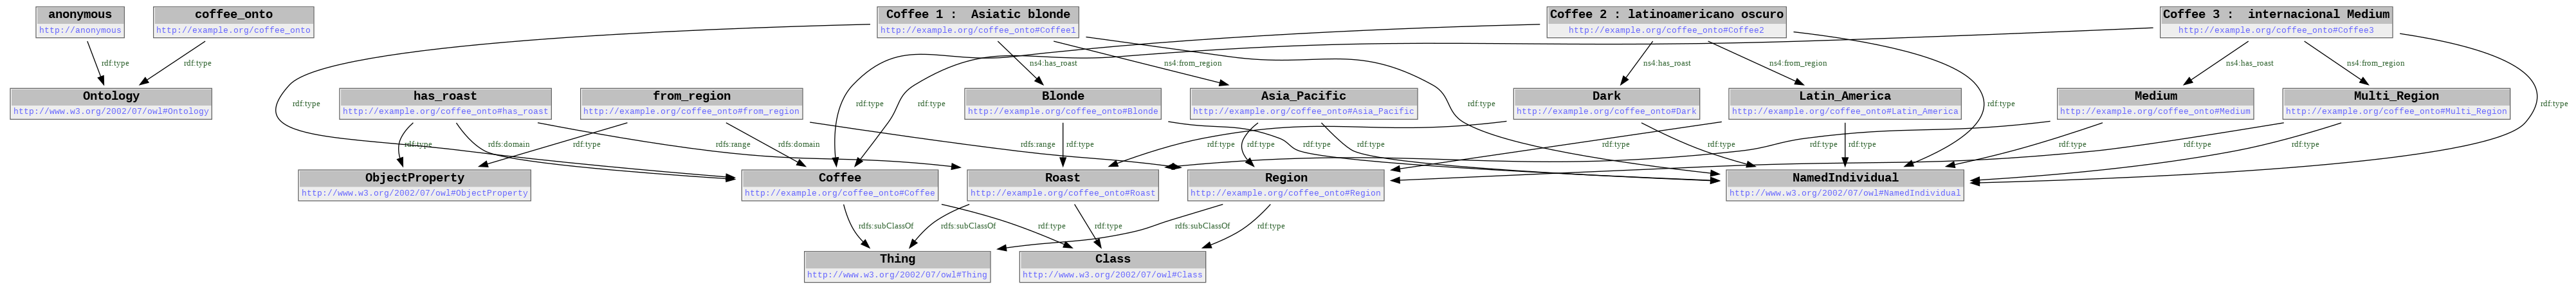

In [157]:
graph = default_world.as_rdflib_graph()
len(graph)
visualize(graph)

A partir de este punto, es posible consultar los elementos de la ontología con las funciones de `rdflib` o con SPARQL.


In [158]:
for h, r, t in graph.triples((None,RDFS.label,None)):
  print( " %s  -- %s --> %s  "  % (h, r ,t) )

 http://example.org/coffee_onto#Coffee1  -- http://www.w3.org/2000/01/rdf-schema#label --> Coffee 1 :  Asiatic blonde  
 http://example.org/coffee_onto#Coffee1  -- http://www.w3.org/2000/01/rdf-schema#label --> Coffee 1 : asiatico rubio  
 http://example.org/coffee_onto#Coffee2  -- http://www.w3.org/2000/01/rdf-schema#label --> Coffee 2 : latinoamericano oscuro  
 http://example.org/coffee_onto#Coffee2  -- http://www.w3.org/2000/01/rdf-schema#label --> Coffee 2 :  Latin American dark  
 http://example.org/coffee_onto#Coffee3  -- http://www.w3.org/2000/01/rdf-schema#label --> Coffee 3 :  internacional Medium  
 http://example.org/coffee_onto#Coffee3  -- http://www.w3.org/2000/01/rdf-schema#label --> Coffee 3 : Internacional medio  


**Q1 - Usando SPARQL obtenga las etiquetas de las instancias de los cafés definidos en la ontología (filtre por un sólo idioma).**

In [161]:
graph.bind("owl", "http://www.w3.org/2002/07/owl#")
graph.bind("rdfs", "http://www.w3.org/2000/01/rdf-schema")
graph.bind("", "http://example.org/coffee_onto#")

result1 = graph.query(""" # TODO
SELECT ?coffee ?label
WHERE {
  ?coffee rdfs:label ?label
  FILTER (langMatches(lang(?label), "es")) 
}
                """ )

for label in result1:
  print(label.label)

Coffee 1 : asiatico rubio
Coffee 2 : latinoamericano oscuro
Coffee 3 : Internacional medio


**Q2 - Obtener el número de cafés que hay definidos por cada una de las regiones**

In [ ]:
result2 = graph.query(""" # TODO
                """ )

for zone in result2:
  pass

**Q3 - Obtener una tabla con los datos donde cada fila es una instancia definida en la ontología y las columnas son el nombre (`label`), el tipo de tostado (`Roast`) y la región de origen (`Region`) (si las hay). **

In [ ]:
result3 = graph.query(""" # TODO
                 """ )


for row in result3:
  pass

In [138]:
coffee_onto.destroy ()